In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
weights = [] #coefficients a_0,..., a_N for each current 
lengths = [l]*len(weights) #lengths of each antenna
positions = [(,,)] #position of each antenna (x, y, z)
spacings = [] #separation between each antenna (can be deduced from the position list)

SyntaxError: invalid syntax (3683312590.py, line 3)

In [12]:
I_0 = 1 #for simplicity and could be adapted with weights
eta = 376.7

def U_dipole(k,l,theta):
    U = (eta*k**2)/(32*np.pi**2)*(l**2)*np.sin(theta)**2
    return U

def U_standing_wave(k,l, theta):
    U = (eta)/(8*np.pi**2*np.sin(theta)**2)*(np.cos(np.cos(theta)*(k*l)/2)-np.cos((k*l)/2))**2
    return U

def U_half_wave(k, l, theta):
    k = 2*np.pi
    l= 1/2
    return U_standing_wave(k, l, theta)

def get_U(atype,k,l,theta):
    """
    1: dipole
    2: standing wave
    3: half wave
    """
    if atype == 1:
        return U_dipole(k,l,theta)
    elif atype == 2:
        return U_standing_wave(k,l,theta)
    elif atype == 3:
        return U_half_wave(k,l,theta)
    else:
        return None
    

In [67]:
def convert_in_dB(U):
    return 10*np.log10(U)

In [76]:
#Uniform spacing

def array_y(k,l, weight, spacing, theta, phi, atype, N):
    U = get_U(atype,k,l,theta)
    k_y = k*np.sin(theta)*np.sin(phi)
    d = spacing
    
    if np.ndim(phi) > 0:
        C =  np.zeros_like(phi, dtype=complex)
        #print(np.ndim(C))
        mask = (phi != 0) & (phi != np.pi)
        C[mask] = (1-np.exp(1j*k_y*N*d))/(1-np.exp(1j*k_y*d))
    else:
        C = (1-np.exp(1j*k_y*N*d))/(1-np.exp(1j*k_y*d))
    
    return abs(C)**2*U

def array_x(k,l, weight, spacing, theta, phi, atype, N):
    U = get_U(atype,k,l,theta)
    k_x = k*np.sin(theta)*np.cos(phi)
    d = spacing
    #print(len(phi))
    if np.ndim(phi) > 0 and np.ndim(theta) > 0:
        C =  np.ones_like(phi, dtype=complex)*N
        mask = (phi != np.pi/2) & (phi != 3*np.pi/2) & (theta != np.pi/2) & (theta != 3*np.pi/2) 
        C[mask] = (1-np.exp(1j*k_x*N*d))/(1-np.exp(1j*k_x*d))
    elif np.ndim(phi) > 0:
        C =  np.ones_like(phi, dtype=complex)*N
        #print(np.ndim(C))
        mask = (phi != np.pi/2) & (phi != 3*np.pi/2)
        C[mask] = (1-np.exp(1j*k_x*N*d))/(1-np.exp(1j*k_x*d))
    else:
        C = weight*(1-np.exp(1j*k_x*N*d))/(1-np.exp(1j*k_x*d))
    
    return abs(C)**2*U


In [77]:
def plot_array_2D_phi(k, l, weight, spacing, atype, N): #uniform spacing + same weight
    """
    k: wavenumber
    l: length of every antenna
    weight: coeff a_n
    spacing: distance between each antenna
    atype: type of antenna
    N: number of antenna
    """
    d = spacing
    theta = np.pi/2 #np.linspace(0, np.pi, 500)
    phi = np.linspace(0, 2*np.pi, 500)
    U_tot = array_x(k, l, weight, spacing, theta, phi, atype, N)
    U_tot = U_tot/ np.max(U_tot)
    
    
    #plot
    plt.figure(figsize=(10, 6))
    plt.plot(np.degrees(phi), U_tot, linewidth=2)
    plt.title(f'Normalized Array Factor (N = {N}, d = {d}λ)', fontsize=14)
    plt.xlabel(r'$\theta$ (degrees)')
    plt.ylabel('Normalized AF (dB)')
    plt.grid(True)
    plt.ylim(0, 1.5)
    #plt.xlim(0, 180)
    plt.axhline(-3, color='red', linestyle='--', label='-3 dB')
    plt.legend()
    plt.show()
    

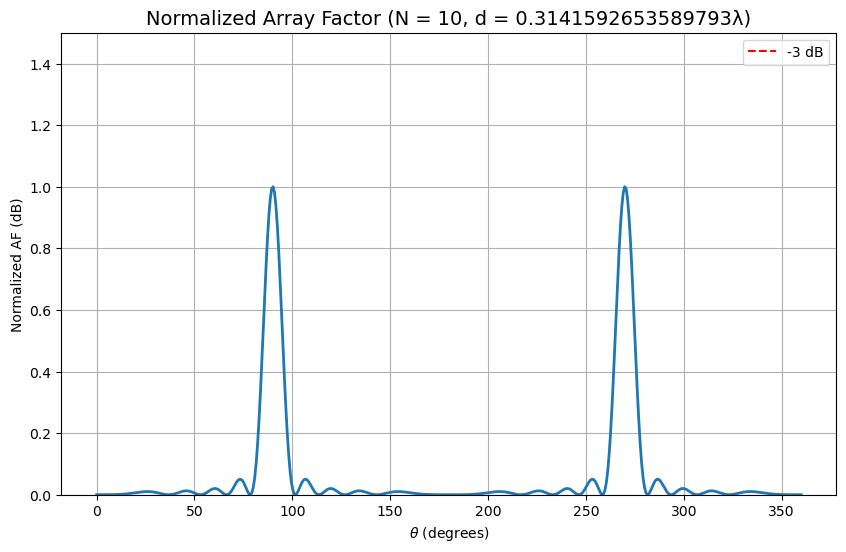

In [78]:
plot_array_2D_phi(10, 10, 1, np.pi/10, 3, 10)

In [79]:
def plot_array_2D_phi2(k, l, weight, spacing, atype, N): #polar plot
    """
    k: wavenumber
    l: length of each antenna element
    weight: array of weights (a_n)
    spacing: distance between antennas
    atype: type of antenna (not used in this snippet)
    N: number of antennas
    """
    d = spacing
    theta = np.pi / 2  # Fixed elevation angle (XY-plane cut)
    phi = np.linspace(0, 2 * np.pi, 500)  # Azimuthal angle
    
    # Compute array factor or total radiation pattern
    U_tot = array_x(k, l, weight, spacing, theta, phi, atype, N)
    U_tot = np.abs(U_tot)
    U_tot = U_tot / np.max(U_tot)  # Normalize for plotting

    # Polar plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    ax.plot(phi, U_tot, linewidth=2)

    ax.set_title(f'Normalized Radiation Pattern\nN={N}, d={d}λ', va='bottom', fontsize=14)
    ax.set_rticks([0.2, 0.4, 0.6, 0.8, 1.0])  # Optional: radius ticks
    ax.grid(True)
    plt.show()

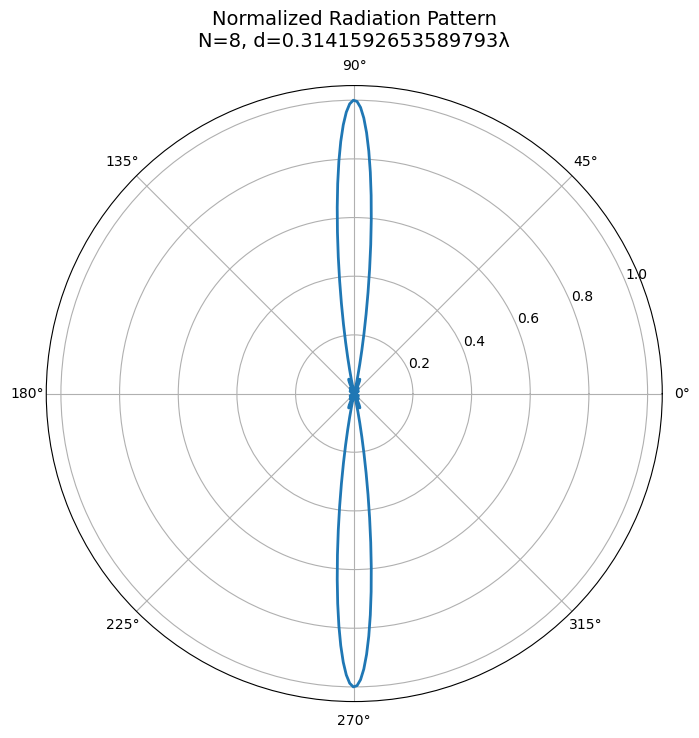

In [80]:
plot_array_2D_phi2(10, 10, 1, np.pi/10, 1, 8)

In [81]:
from mpl_toolkits.mplot3d import Axes3D

def plot_array_3D(k, l, weight, spacing, atype, N):
    """
    3D plot of the array factor over theta and phi.
    """
    # Angular grid
    theta = np.linspace(0, np.pi, 200)  # elevation angle
    phi = np.linspace(0, 2 * np.pi, 200)  # azimuthal angle
    THETA, PHI = np.meshgrid(theta, phi)

    # Flatten angles to evaluate function
    theta_flat = THETA.ravel()
    phi_flat = PHI.ravel()

    # Evaluate array factor on the grid
    U_flat = array_x(k, l, weight, spacing, theta_flat, phi_flat, atype, N)
    U = np.abs(U_flat).reshape(THETA.shape)
    U = U / np.max(U)  # Normalize

    # Convert to Cartesian for plotting
    X = U * np.sin(THETA) * np.cos(PHI)
    Y = U * np.sin(THETA) * np.sin(PHI)
    Z = U * np.cos(THETA)

    # Plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.viridis(U), rstride=1, cstride=1, linewidth=0, antialiased=False)

    ax.set_title(f'3D Normalized Radiation Pattern (N = {N}, d = {spacing}λ)', fontsize=14)
    ax.set_box_aspect([1,1,1])
    plt.tight_layout()
    plt.show()


C:\Users\mattc\AppData\Local\Temp\ipykernel_67132\3333148624.py:26: RuntimeWarning: invalid value encountered in divide
  C[mask] = (1-np.exp(1j*k_x*N*d))/(1-np.exp(1j*k_x*d))


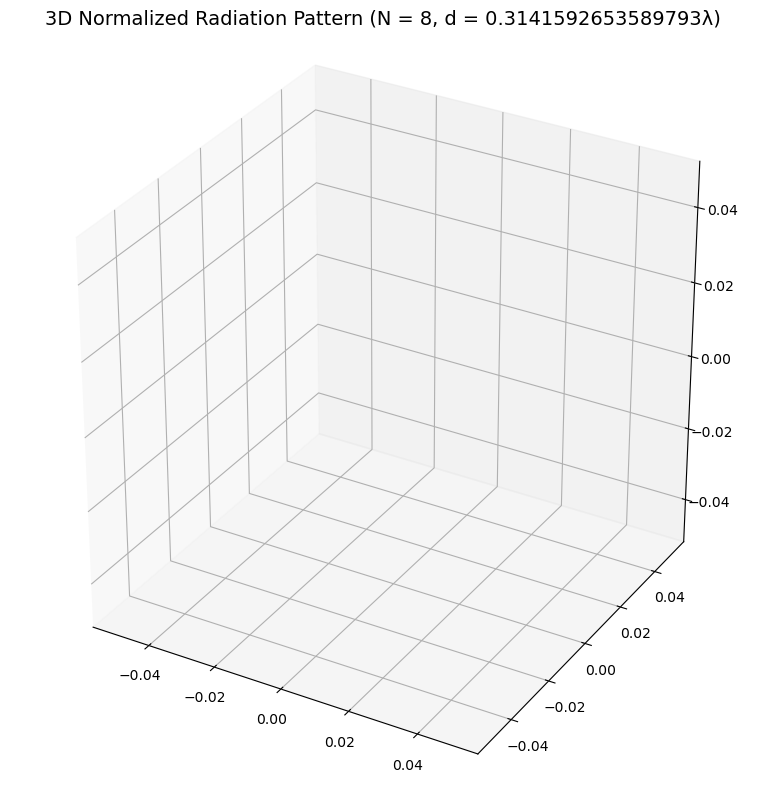

In [82]:
plot_array_3D(10, 10, 1, np.pi/10, 1, 8)